###  Modèle type LeNet base mendeley seule

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_mendeley.csv',index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17092 entries, 0 to 17091
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  17092 non-null  object
 1   filename   17092 non-null  object
 2   class      17092 non-null  object
 3   size       17092 non-null  object
dtypes: object(4)
memory usage: 667.7+ KB


In [4]:
lst_classes = {'basophil':0,'eosinophil':1,
               'erythroblast':2,'ig':3,'lymphocyte':4,'monocyte':5,'neutrophil':6,'platelet':7}

In [5]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [6]:
data.head()

,file_path,filename,class,size,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,363x360,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,363x360,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,363x360,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,363x360,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,363x360,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17092 entries, 0 to 17091
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  17092 non-null  object
 1   filename   17092 non-null  object
 2   class      17092 non-null  object
 3   size       17092 non-null  object
 4   label      17092 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [8]:
data['class'].value_counts()

neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: class, dtype: int64

In [9]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [10]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) 
    img = tf.cast(img, tf.float32)/255
    return img

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam

In [13]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [14]:
# Création d'un modèle CNN type LeNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=8,activation='softmax')) #8Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = model_CNN()

In [17]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
433/433 [==============================] - 686s 2s/step - loss: 1.1856 - accuracy: 0.5592 - val_loss: 0.8409 - val_accuracy: 0.6803
Epoch 2/16
433/433 [==============================] - 665s 2s/step - loss: 0.6196 - accuracy: 0.7739 - val_loss: 0.5749 - val_accuracy: 0.7804
Epoch 3/16
433/433 [==============================] - 686s 2s/step - loss: 0.4052 - accuracy: 0.8577 - val_loss: 0.3940 - val_accuracy: 0.8571
Epoch 4/16
433/433 [==============================] - 691s 2s/step - loss: 0.3131 - accuracy: 0.8920 - val_loss: 0.3543 - val_accuracy: 0.8700
Epoch 5/16
433/433 [==============================] - 685s 2s/step - loss: 0.2488 - accuracy: 0.9163 - val_loss: 0.2973 - val_accuracy: 0.8915
Epoch 6/16
433/433 [==============================] - 698s 2s/step - loss: 0.2021 - accuracy: 0.9321 - val_loss: 0.2696 - val_accuracy: 0.9077
Epoch 7/16
433/433 [==============================] - 681s 2s/step - loss: 0.1662 - accuracy: 0.9432 - val_loss: 0.2632 - val_accuracy: 0.8973

In [18]:
model.save_weights("cnn_8_weights_1_base")

#### Prédiction sur les données d'évaluation

In [19]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [20]:
model.evaluate(dataset_eval)

54/54 [==============================] - 22s 398ms/step - loss: 0.2289 - accuracy: 0.9187


[0.22892425954341888, 0.9187134504318237]

* Score de 92 %

In [21]:
#Classes prédites
predict = model.predict(dataset_eval)

In [22]:
lst_classes = ['basophil','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.86      0.90      0.88       118
  eosinophil       0.97      0.98      0.98       300
erythroblast       0.89      0.89      0.89       141
          ig       0.80      0.91      0.85       290
  lymphocyte       0.91      0.84      0.87       120
    monocyte       0.93      0.77      0.84       168
  neutrophil       0.97      0.95      0.96       346
    platelet       1.00      0.99      0.99       227

    accuracy                           0.92      1710
   macro avg       0.92      0.90      0.91      1710
weighted avg       0.92      0.92      0.92      1710



> Plus faible score sur ig et monocyte

In [23]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,106,2,0,8,1,0,1,0
eosinophil,1,294,2,1,0,0,2,0
erythroblast,0,0,126,5,8,1,0,1
ig,8,3,1,264,1,6,7,0
lymphocyte,2,0,6,10,101,1,0,0
monocyte,3,0,1,35,0,129,0,0
neutrophil,3,4,2,9,0,1,327,0
platelet,0,0,3,0,0,0,0,224


> Confusion importante neutrophil/IG ainsi que monocyte/IG


### GRAD CAM

In [24]:
import gradcam_dataset

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [26]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

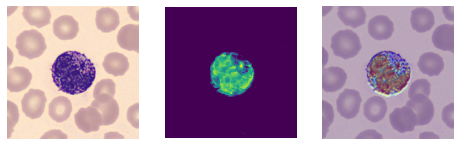

In [27]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### EOSINOPHIL

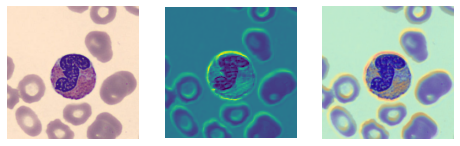

In [28]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### ERYTHROBLAST

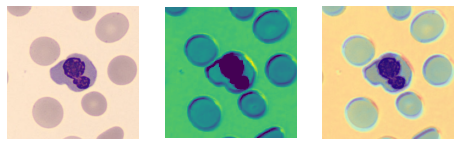

In [29]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### IG

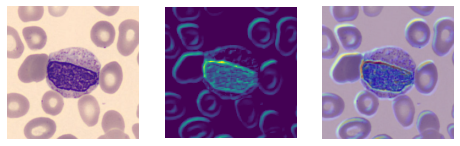

In [30]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### LYMPHOCYTE

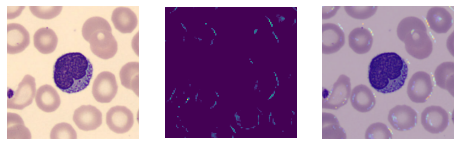

In [31]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### MONOCYTE

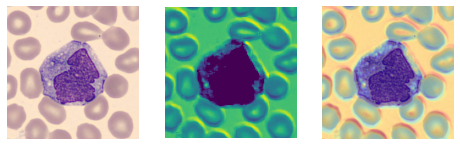

In [32]:
path = data[data['filename']=='MO_60562.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### NEUTROPHIL

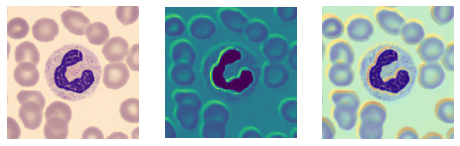

In [33]:
path = data[data['filename']=='BNE_53394.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### PLATELET

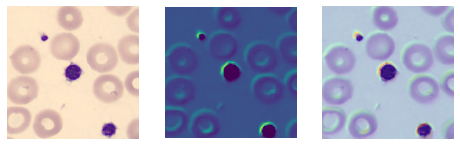

In [34]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)